In [1]:
import dask
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmcrameri as cm
import os
from moarpalettes import get_palette
import matplotlib.gridspec as gridspec  
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
import babet as bb

In [3]:
pnw = [-123, -119, 45, 52] # lon min, lon max, lat min, lat max
west_coast = [-150, -100, 30, 70]
palette = get_palette.Petroff6().to_sn_palette()
palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.611764705882353, 0.611764705882353, 0.6313725490196078),
 (0.47843137254901963, 0.12941176470588237, 0.8666666666666667)]

In [4]:
cf_option = ['cf', 'pf']
exp_option = ['pi', 'curr', 'incr']
perturb_option = ['q_and_t', 'progn_vars']

base_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/ITERATION/MED-R/EXP/{}/US025/sfc/{}'
expver_dict = {'pi': ['b2us', 'b2uu'],
                'curr': ['b2ut'],
                'incr': ['b2v0', 'b2v1']}
perturb_dict = {'b2us': 't+q',
             'b2uu': 'progn_vars',
             'b2ut': 'none',
             'b2v0': 't+q',
             'b2v1': 'progn_vars'}

# collect per-climate datasets (each will have climate dim length 1)
climate_dsets = []

for exp in exp_option:
    # collect per-perturbation datasets for this climate
    perturb_dsets = []
    for expver in expver_dict[exp]:
        # collect files/variants that should map to 'number'
        number_dsets = []
        for c in cf_option:
            dir_path = os.path.join(base_dir.format(exp, c), f'{expver}*.nc')
            ds = xr.open_mfdataset(
                dir_path,
                engine='netcdf4',
                preprocess=bb.data.Data.preproc_ds_v2
            ).get(['t2m', 'msl', 'tcwv'])

            # give single-file/collection the scalar dims climate & perturbation
            ds = ds.expand_dims(climate=[exp], perturbation=[perturb_dict[expver]])
            number_dsets.append(ds)

        # concat the list of 'number' variants into the number dimension
        # (if cf_option has length 1 this will still be fine)
        perturb_ds = xr.concat(number_dsets, dim='number')
        perturb_dsets.append(perturb_ds)

    # concat all perturbations for THIS climate along 'perturbation'
    climate_ds = xr.concat(perturb_dsets, dim='perturbation')
    climate_dsets.append(climate_ds)

# finally concat across climates
ifs = xr.concat(climate_dsets, dim='climate')

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/core.py:4608: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/home/e/ermis/noback

In [ ]:
ifs_pnw = ifs.sel(longitude=slice(pnw[0], pnw[1]), latitude=slice(pnw[3], pnw[2])).mean(dim=['latitude', 'longitude'])

# daily maximum 2m temperature
t2m_daily_max = ifs_pnw.t2m.resample(time='1D').max().compute() - 273.15  # convert to degiC

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/array/reductions.py:569: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


In [78]:
ifs_pnw

,Array,Chunk
Bytes,3.39 MiB,3.71 kiB
Shape,"(3, 3, 129, 51, 15)","(1, 1, 19, 50, 1)"
Count,23966 Tasks,1890 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,3.39 MiB,3.71 kiB
Shape,"(3, 3, 129, 51, 15)","(1, 1, 19, 50, 1)"
Count,23966 Tasks,1890 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# Temperature plots

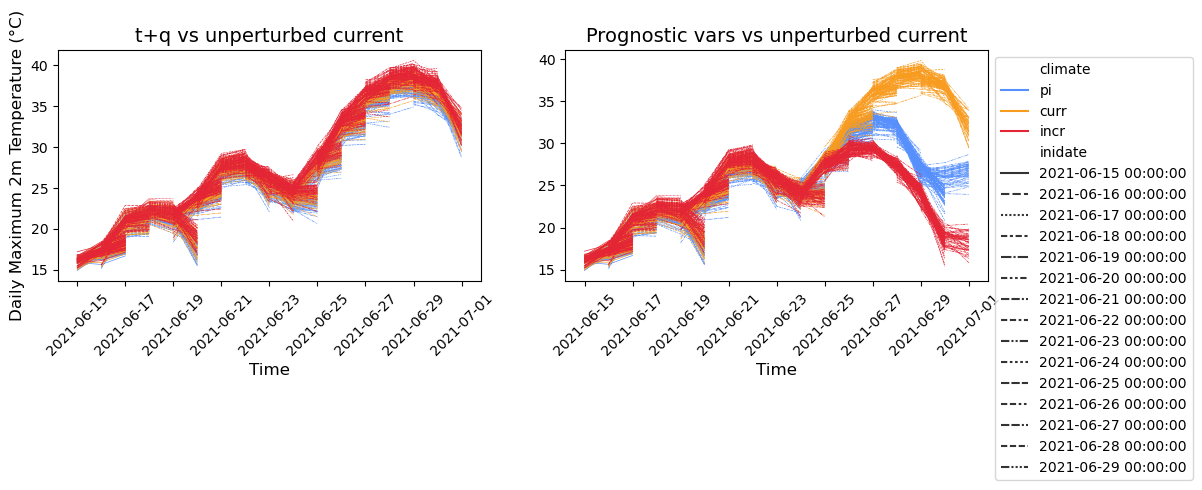

In [15]:
plt.figure(figsize=(12,3))

ax1 = plt.subplot(1,2,1)
sns.lineplot(data=t2m_daily_max.where(t2m_daily_max.perturbation.isin(['t+q', 'none']), drop=True).to_dataframe(), 
             x='time', y='t2m', 
             hue='climate', 
             style='inidate',
             linewidth=0.5,
             units='number',
             estimator=None,
             palette=palette[0:3], 
             ax=ax1, 
             legend=False)
plt.xticks(rotation=45)
plt.ylabel('Daily Maximum 2m Temperature (°C)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('t+q vs unperturbed current', fontsize=14)

ax2 = plt.subplot(1,2,2)
sns.lineplot(data=t2m_daily_max.where(t2m_daily_max.perturbation.isin(['progn_vars', 'none']), drop=True).to_dataframe(), 
             x='time', y='t2m', 
             hue='climate', 
             style='inidate',
             linewidth=0.5,
             units='number',
             estimator=None,
             palette=palette[0:3], 
             ax=ax2)
plt.xticks(rotation=45)
plt.ylabel('', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Prognostic vars vs unperturbed current', fontsize=14)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

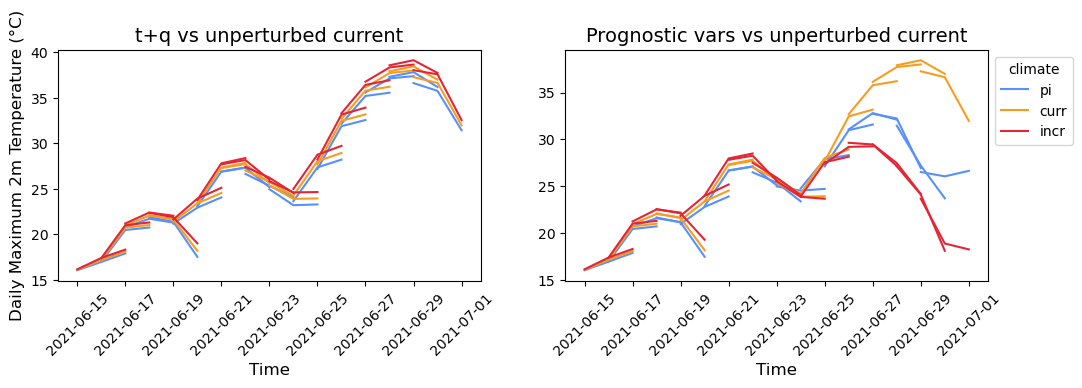

In [18]:
plt.figure(figsize=(12,3))

ax1 = plt.subplot(1,2,1)
sns.lineplot(data=t2m_daily_max.where(t2m_daily_max.perturbation.isin(['t+q', 'none']), drop=True).mean('number').to_dataframe(), 
             x='time', y='t2m', 
             hue='climate', 
             units='inidate',
            #  units='number',
             estimator=None,
             palette=palette[0:3], 
             ax=ax1, 
             legend=False)
plt.xticks(rotation=45)
plt.ylabel('Daily Maximum 2m Temperature (°C)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('t+q vs unperturbed current', fontsize=14)

ax2 = plt.subplot(1,2,2)
sns.lineplot(data=t2m_daily_max.where(t2m_daily_max.perturbation.isin(['progn_vars', 'none']), drop=True).mean('number').to_dataframe(), 
             x='time', y='t2m', 
             hue='climate', 
             units='inidate',
            #  units='number',
             estimator=None,
             palette=palette[0:3], 
             ax=ax2)
plt.xticks(rotation=45)
plt.ylabel('', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Prognostic vars vs unperturbed current', fontsize=14)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

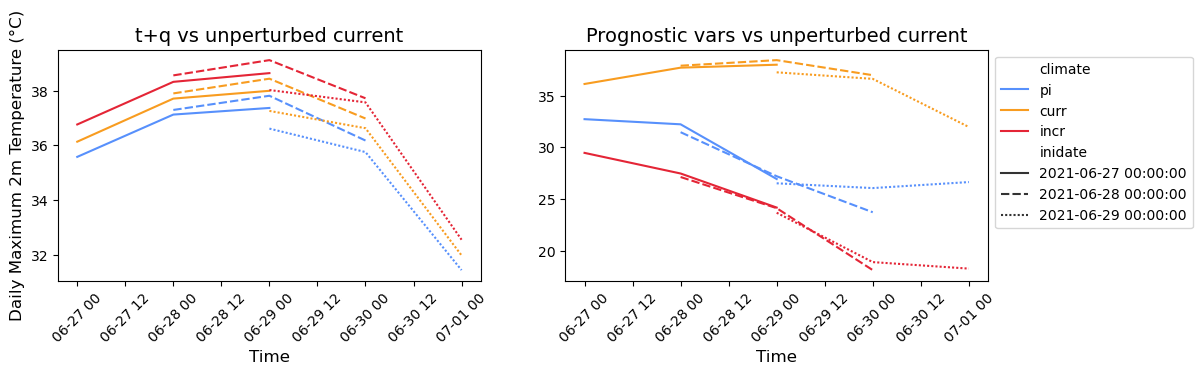

In [25]:
plt.figure(figsize=(12,3))

ax1 = plt.subplot(1,2,1)
sns.lineplot(data=t2m_daily_max.where(t2m_daily_max.perturbation.isin(['t+q', 'none']), drop=True).mean('number').sel(inidate=slice('2021-06-27', '2021-06-29')).to_dataframe(), 
             x='time', y='t2m', 
             hue='climate', 
             style='inidate',
            #  linewidth=0.5,
            #  units='number',
             estimator=None,
             palette=palette[0:3], 
             ax=ax1, 
             legend=False)
plt.xticks(rotation=45)
plt.ylabel('Daily Maximum 2m Temperature (°C)', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('t+q vs unperturbed current', fontsize=14)

ax2 = plt.subplot(1,2,2)
sns.lineplot(data=t2m_daily_max.where(t2m_daily_max.perturbation.isin(['progn_vars', 'none']), drop=True).mean('number').sel(inidate=slice('2021-06-27', '2021-06-29')).to_dataframe(), 
             x='time', y='t2m', 
             hue='climate', 
             style='inidate',
            #  linewidth=0.5,
            #  units='number',
             estimator=None,
             palette=palette[0:3], 
             ax=ax2)
plt.xticks(rotation=45)
plt.ylabel('', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.title('Prognostic vars vs unperturbed current', fontsize=14)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))

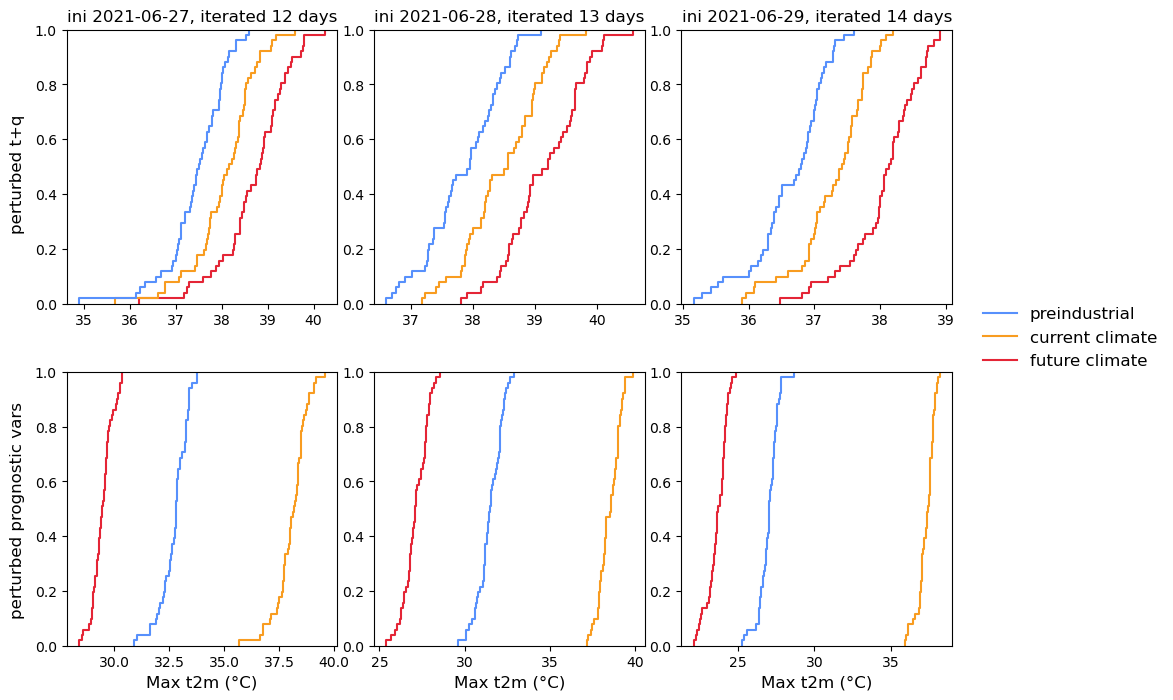

In [7]:
max_t2m_hw = t2m_daily_max.max(dim='time').sel(inidate=slice('2021-06-27', '2021-06-29'))
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1, 1, 0.6],
                       wspace=0.15, hspace=0.25)

for p, pert in enumerate(['t+q', 'progn_vars']):
    for i, inidate in enumerate(max_t2m_hw.inidate.values):
        ax = fig.add_subplot(gs[p, i])
        sns.ecdfplot(
            data=max_t2m_hw
                .sel(inidate=inidate)
                .where(t2m_daily_max.perturbation.isin([pert, 'none']), drop=True)
                .to_dataframe(),
            x='t2m',
            hue='climate',
            palette=palette[0:3],
            legend=False,
            ax=ax
        )

        if p == 0:
            ax.set_title(f'ini {np.datetime_as_string(inidate, unit="D")}, iterated {12+i} days', fontsize=12)
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Max t2m (°C)', fontsize=12)

        ax.set_ylabel('')

# legend panel
from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color=palette[0], label='preindustrial'),
    Line2D([0], [0], color=palette[1], label='current climate'),
    Line2D([0], [0], color=palette[2], label='future climate'),
]
ax_legend = fig.add_subplot(gs[:, 3])
ax_legend.axis('off')
ax_legend.legend(handles=handles, loc='center', fontsize=12, frameon=False)

# Add row labels on the left
row_labels = ["perturbed t+q", "perturbed prognostic vars"]
y_positions = [0.7, 0.28]  # top → bottom (tune if needed)

for label, y in zip(row_labels, y_positions):
    fig.text(
        0.09, y, label,
        va='center', ha='center',
        rotation=90,
        fontsize=12
    )

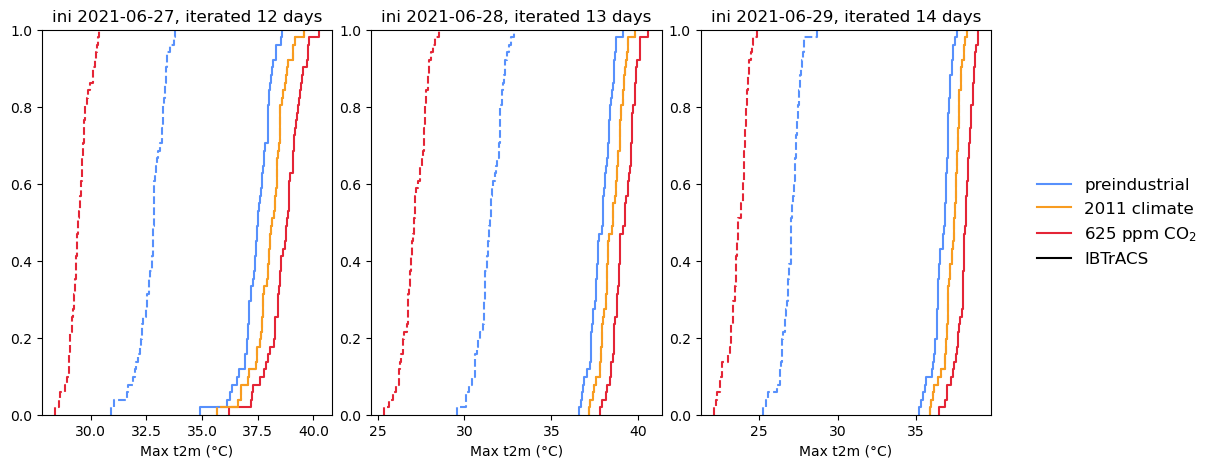

In [29]:
linestyles = {
    't+q': '-',
    'progn_vars': '--'
}

fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 0.6], wspace=0.15)

for i, inidate in enumerate(t2m_daily_max.inidate.values):
    ax = fig.add_subplot(gs[0, i])

    for pert in ['t+q', 'progn_vars']:
        sns.ecdfplot(
            data=max_t2m_hw
                .sel(inidate=inidate)
                .where(t2m_daily_max.perturbation.isin([pert, 'none']), drop=True)
                .to_dataframe(),
            x='t2m',
            hue='climate',
            palette=palette[0:3],
            linestyle=linestyles[pert],
            legend=False,
            ax=ax
        )

    ax.set_title(f'ini {np.datetime_as_string(inidate, unit="D")}, iterated {12+i} days', fontsize=12)
    ax.set_xlabel('Max t2m (°C)')
    ax.set_ylabel('')

# legend panel
ax_legend = fig.add_subplot(gs[0, 3])
ax_legend.axis('off')
ax_legend.legend(handles=handles, loc='center', fontsize=12, frameon=False)

# MSLP patterns

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


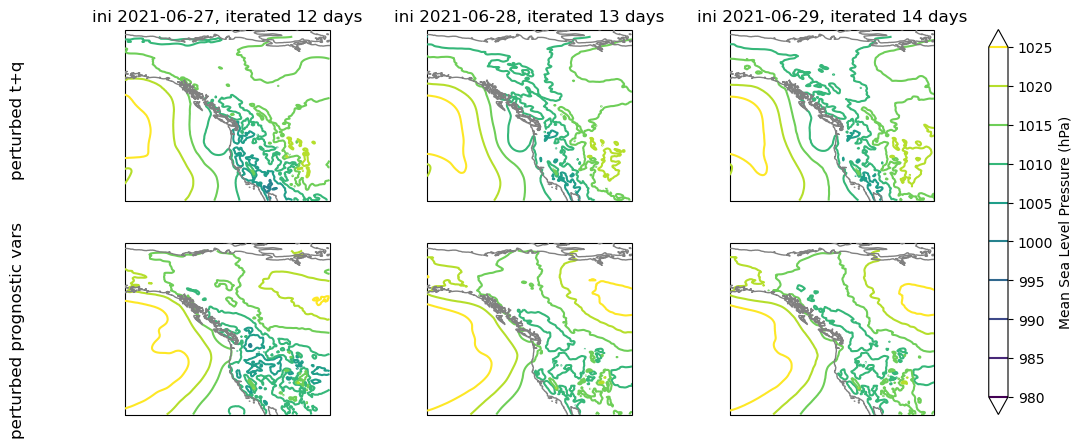

In [53]:
mslp_29th = ifs.msl.sel(inidate=slice('2021-06-27', '2021-06-29')).resample(time='1D').mean(dim='time').sel(time='2021-06-29') / 100  # convert to hPa
projection = ccrs.PlateCarree()

fig = plt.figure(figsize=(14,5))
gs = gridspec.GridSpec(2, len(mslp_29th.inidate.values),
                       width_ratios=[1]*len(mslp_29th.inidate.values),
                       wspace=0.15, hspace=0.25)

for p, pert in enumerate(['t+q', 'progn_vars']):
    for i, inidate in enumerate(mslp_29th.inidate.values):
        ax = fig.add_subplot(gs[p, i], projection=projection)
        ax.set_extent(west_coast)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'gray', zorder = 14)

        cs = ax.contour(
            mslp_29th.longitude,
            mslp_29th.latitude,
            mslp_29th.sel(inidate=inidate, perturbation=pert, climate='pi').mean(dim='number'),
            levels=np.arange(980, 1030, 5),
            # cmap=cm.cm.vik,
            extend='both',
            transform=ccrs.PlateCarree(),
            # colors='black',
            zorder=10
        )

        if p == 0:
            ax.set_title(f'ini {np.datetime_as_string(inidate, unit="D")}, iterated {12+i} days', fontsize=12)
            ax.set_xlabel('')
        else:
            ax.set_ylabel('')
        # plt.clabel(cs, fmt='%d')

# Add row labels on the left
row_labels = ["perturbed t+q", "perturbed prognostic vars"]
y_positions = [0.7, 0.28]  # top → bottom (tune if needed)

for label, y in zip(row_labels, y_positions):
    fig.text(
        0.09, y, label,
        va='center', ha='center',
        rotation=90,
        fontsize=12
    )
plt.tight_layout()
plt.colorbar(cs, ax=fig.axes, orientation='vertical', label='Mean Sea Level Pressure (hPa)')

<!-- # t2m delta progression -->

In [8]:
def diff_with_offset(a, b, dim="inidate", offset=1):
    return a.isel({dim: slice(0, -offset)}) - b.isel({dim: slice(offset, None)})

In [24]:
# global at 00UTC difference to the previous initidalisation

deltas = {}
for climate in ['pi', 'incr']:
    deltas[climate] = {}
    for pert in ['t+q', 'progn_vars']:
        tmp1 = ifs.sel(perturbation=pert, climate=climate)
        tmp2 = ifs.sel(perturbation='none', climate='curr')
        ifs_diff = diff_with_offset(tmp1, tmp2, dim='inidate', offset=1)

        ifs_diff_delta = []

        for i, ini in enumerate(ifs_diff.inidate.values):
            inidate_data = ifs_diff.sel(inidate=ini)
            timesteps = [ini+np.timedelta64(0,'h')] #[ini+np.timedelta64(0, 'h'), ini+np.timedelta64(24, 'h')]
            ifs_diff_delta.append(inidate_data.sel(time=timesteps).squeeze('time', drop=True))

        ifs_diff_delta = xr.concat(ifs_diff_delta, dim='inidate')
        deltas[climate][pert] = ifs_diff_delta.mean(dim=['number', 'latitude', 'longitude']).compute()

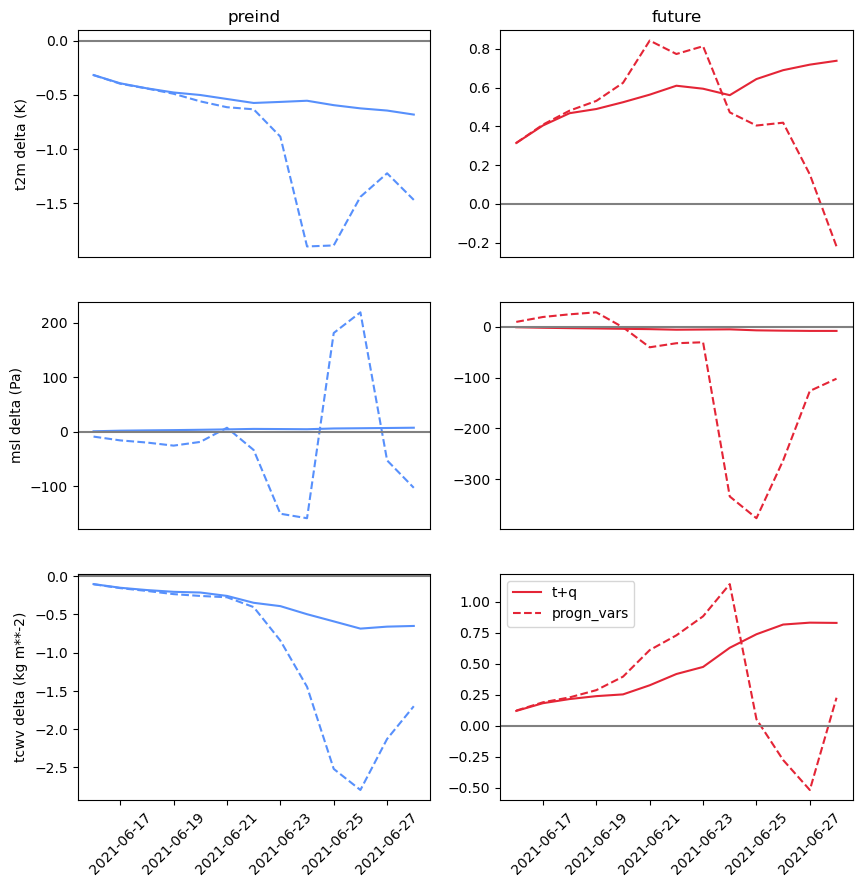

In [77]:
plt.figure(figsize=(10,10))
for v, var in enumerate(['t2m', 'msl', 'tcwv']):
    ax = plt.subplot(3,2,1+v*2)
    ax.plot(deltas['pi']['t+q'].inidate, deltas['pi']['t+q'][var], color=palette[0], linestyle='-')
    ax.plot(deltas['pi']['progn_vars'].inidate, deltas['pi']['progn_vars'][var], color=palette[0], linestyle='--')
    plt.ylabel(f'{var} delta ({ifs[var].units})')
    plt.axhline(0, color='gray', linestyle='-')

    if v == 2:
        plt.xticks(rotation=45)
    elif v == 0:
        plt.title('preind')
        ax.set_xticks([])
    elif v == 1:
        ax.set_xticks([])

    ax = plt.subplot(3,2,2+v*2)
    ax.plot(deltas['incr']['t+q'].inidate, deltas['incr']['t+q'][var],  color=palette[2], linestyle='-', label='t+q')
    ax.plot(deltas['incr']['progn_vars'].inidate, deltas['incr']['progn_vars'][var], color=palette[2], linestyle='--', label='progn_vars')
    plt.ylabel('')
    plt.axhline(0, color='gray', linestyle='-')

    if v == 2:
        plt.xticks(rotation=45)
        plt.legend(loc='upper left')
    elif v == 0:
        plt.title('future')
        ax.set_xticks([])
    elif v == 1:
        ax.set_xticks([])